In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import linregress
from sklearn.model_selection import KFold

import matplotlib
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

import sys

sys.path.append("../../models")
from linear_cr_new import LinearContrastiveRegression

In [3]:
# Load data
data_dir = "./data/"
X = np.load(pjoin(data_dir, "foreground.npy"))
Y = np.load(pjoin(data_dir, "background.npy"))
R = np.load(pjoin(data_dir, "foreground_labels.npy")).reshape(-1, 1)

# rand_idx = np.random.choice(np.arange(len(X)), size=200, replace=False)
# X = X[rand_idx]
# R = R[rand_idx]
# rand_idx = np.random.choice(np.arange(len(Y)), size=200, replace=False)
# Y = Y[rand_idx]

X_mean, Y_mean, R_mean = np.mean(X, axis=0), np.mean(Y, axis=0), np.mean(R, axis=0)
X = (X - X_mean) / np.std(X, axis=0)
Y = (Y - Y_mean) / np.std(Y, axis=0)
R = (R - R_mean) / np.std(R, axis=0)

n, p = X.shape
m, _ = Y.shape
d = 2


In [5]:
X.shape, Y.shape, R.shape

((2500, 784), (2500, 784), (2500, 1))

In [6]:
model = LinearContrastiveRegression()
model.fit(X, Y, R, d, print_every=100)

2024-07-23 15:48:18.177655: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  dot.14 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-07-23 15:48:21.326930: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4.160108s
Constant folding an instruction is taking > 1s:

  dot.14 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessaril

Step: 0               Log marginal lik.: -1969837.5
Step: 100             Log marginal lik.: -600263.81
Step: 200             Log marginal lik.: -597624.94
Step: 300             Log marginal lik.: -596596.19
Step: 400             Log marginal lik.: -596064.56
Step: 500             Log marginal lik.: -595762.19
Step: 600             Log marginal lik.: -595580.0
Step: 700             Log marginal lik.: -595464.25


In [7]:
# Make predictions
preds_contrastivereg = model.predict(X)
_, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds_contrastivereg)

# Compare against PCA + linear regression
linreg = LinearRegression()
X_reduced = PCA(n_components=d).fit_transform(X)
linreg.fit(X_reduced, R)
preds_linreg = linreg.predict(X_reduced)
_, _, r2_linreg, _, _ = linregress(R.squeeze(), preds_linreg.squeeze())


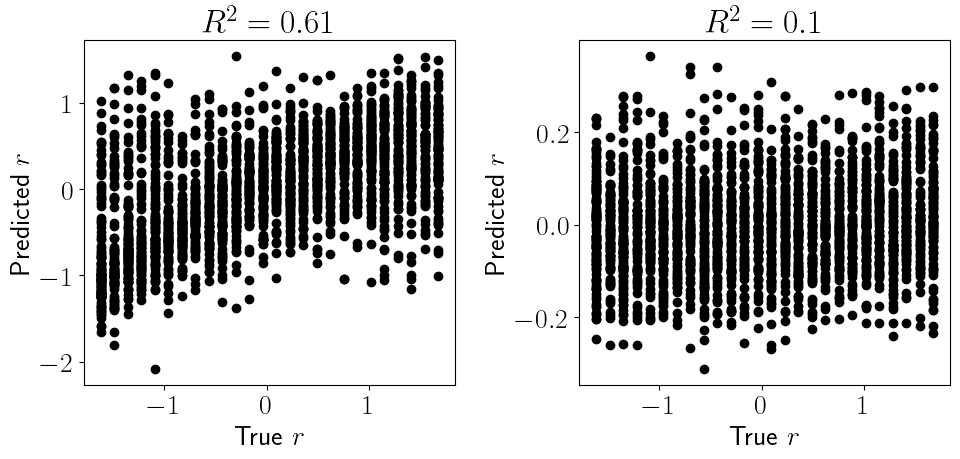

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(R, preds_contrastivereg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.subplot(122)
plt.scatter(R, preds_linreg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"$R^2 = " + str(round(r2_linreg, 2)) + "$")

plt.tight_layout()
plt.show()

In [11]:
# Now do this prediction experiment on held-out data
n_splits = 3
r2_scores_contrastivereg = []
r2_scores_linreg = []

kf = KFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in kf.split(X):
    
    # Train/test split
    X_train, Y_train, R_train = X[train_index], Y[train_index], R[train_index]
    X_test, Y_test, R_test = X[test_index], Y[test_index], R[test_index]
    
    # Fit model on training data
    model = LinearContrastiveRegression()
    model.fit(X_train, Y_train, R_train, d, print_every=100)
    
    # Make predictions
    preds_contrastivereg = model.predict(X_test)
    
    # Compute R^2
    _, _, r2_contrastivereg, _, _ = linregress(R_test.squeeze(), preds_contrastivereg)
    r2_scores_contrastivereg.append(r2_contrastivereg)
    
    linreg = LinearRegression()
    X_reduced = PCA(n_components=d).fit_transform(X)
    linreg.fit(X_reduced[train_index], R_train)
    preds_linreg = linreg.predict(X_reduced[test_index])
    _, _, r2_linreg, _, _ = linregress(R_test.squeeze(), preds_linreg.squeeze())
    r2_scores_linreg.append(r2_linreg)

Step: 0               Log marginal lik.: -1305592.25
Step: 100             Log marginal lik.: -409503.31
Step: 200             Log marginal lik.: -407925.34
Step: 300             Log marginal lik.: -407268.94
Step: 400             Log marginal lik.: -406928.53
Step: 500             Log marginal lik.: -406736.12
Step: 600             Log marginal lik.: -406619.88
Step: 700             Log marginal lik.: -406546.88
Step: 800             Log marginal lik.: -406499.31
Step: 0               Log marginal lik.: -1324002.75
Step: 100             Log marginal lik.: -402651.28
Step: 200             Log marginal lik.: -400910.19
Step: 300             Log marginal lik.: -400220.91
Step: 400             Log marginal lik.: -399859.62
Step: 500             Log marginal lik.: -399653.72
Step: 600             Log marginal lik.: -399529.38
Step: 700             Log marginal lik.: -399450.75
Step: 0               Log marginal lik.: -1310080.12
Step: 100             Log marginal lik.: -385786.75
Step: 200

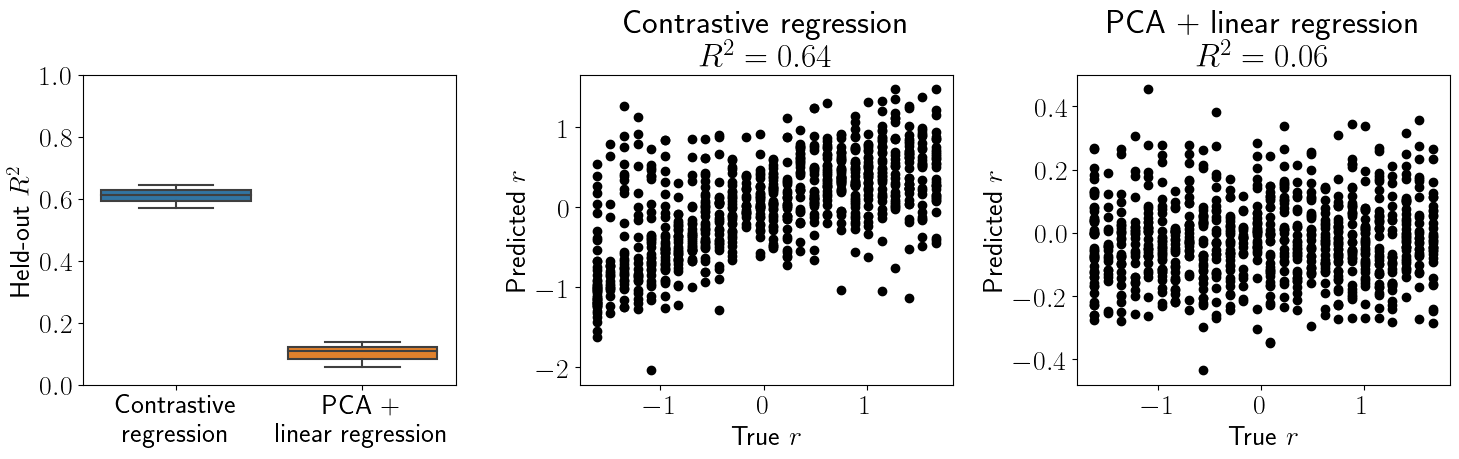

In [13]:
results_df = pd.DataFrame(
    {
        "Method": np.concatenate([["Contrastive\nregression"] * n_splits, ["PCA +\nlinear regression"] * n_splits]),
        "R2": np.concatenate([r2_scores_contrastivereg, r2_scores_linreg])
    }
)
results_df.to_csv('./out/corrupted_lines_R2.csv', index=False)

plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.boxplot(data=results_df, x="Method", y="R2")
plt.xlabel("")
plt.ylabel(r"Held-out $R^2$")
plt.ylim([0, 1])

plt.subplot(132)
plt.scatter(R_test, preds_contrastivereg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("Contrastive regression\n" + r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.subplot(133)
plt.scatter(R_test, preds_linreg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("PCA + linear regression\n" + r"$R^2 = " + str(round(r2_linreg, 2)) + "$")

plt.tight_layout()
plt.savefig("./out/corrupted_lines_preds.png", dpi = 300)
plt.show()